# Imports and Installations

In [1]:
#First install pyRDDL as following

!pip install -q git+https://github.com/tasbolat1/pyRDDLGym.git --force-reinstall

## Install other packages if needed

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.2 which is incompatible.
dopamine-rl 4.0.6 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import itertools
import numpy as np
import random
import tqdm
import matplotlib.pyplot as plt
from collections import deque

from pyRDDLGym.Visualizer.MovieGenerator import MovieGenerator # loads visualizer utilites
from IPython.display import Image, display, clear_output # for displaying gifs in colab
from pyRDDLGym.Elevator import Elevator # imports Discrete Elevator

In [3]:
# Extra imports
from torch.distributions import Categorical

# Environment Initialization

In [42]:
env = Elevator(instance = 4)
print('Discrete environment actions:')
print(env.disc_actions)
print('Continuous environment actions:')
print(env.base_env.action_space)
print(f"Observation space size for the discrete Elevator Environment: {len(env.disc_states)}")

/usr/local/lib/python3.10/dist-packages/pyRDDLGym/Examples /usr/local/lib/python3.10/dist-packages/pyRDDLGym/Examples/manifest.csv
Available example environment(s):
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
CartPole_continuous -> A simple continuous state-action MDP for the classical cart-pole system by Rich Sutton, with actions that describe the continuous force applied to the cart.
SupplyChain -> A supply chain with factory and multiple warehouses.
NewLanguage -> Example with new language features.
NewtonZero -> Example with Newton root-finding method.
PropDBN -> Simple propositional DBN.
SupplyChainNet -> A supply chain network with factory and multiple warehouses.
Traffic -> BLX/QTM traffic model.
Wildfire -> A boolean version of the wildfire fighting domain.
MountainCar -> A simple continuous MDP for the classical mountain car 

/usr/local/lib/python3.10/dist-packages/pyRDDLGym/Core/Env/RDDLConstraints.py:85: UserWarning: Constraint does not have a structure of <action or state fluent> <op> <rhs>, where:
<op> is one of {<=, <, >=, >}
<rhs> is a deterministic function of non-fluents or constants only.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(


Discrete environment actions:
{0: ('e0_movcurdir_0',), 1: ('e0_movcurdir_1',), 2: ('e0_close_0',), 3: ('e0_close_1',), 4: ('e0_open_0',), 5: ('e0_open_1',)}
Continuous environment actions:
Dict('move-current-dir___e0': Discrete(2), 'open-door___e0': Discrete(2), 'close-door___e0': Discrete(2))
Observation space size for the discrete Elevator Environment: 45056


# Hyperparameters

In [43]:
# Define hyperparameters

## IMPORTANT: <BEGIN> DO NOT CHANGE THIS CODE!
## GENERAL HYPERPARAMS
num_episodes = 3000
## IMPORTANT: <END> DO NOT CHANGE THIS CODE!

learning_rate = 3e-4
batch_size = 64
clip_value = 0.2  # Gradient clipping value

## ALGO SPECIFIC HYPERPARAMS
# Update the hyperparams as necessary for your implementation
K_epochs = 80
gamma = 0.95
state_dim = 11
action_dim = 6
lr_actor = 0.0003
lr_critic = 0.001

# Model Definition (COPY THIS OVER TO your AGENT.PY)


In [44]:
# Define the Model here - all component models (in case of actor-critic or others) MUST subclass nn.Module
class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        # Your model layers and initializations here
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.gamma = gamma
        self.eps_clip = clip_value
        self.K_epochs = K_epochs
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(self.state_dim, self.action_dim).to(self.device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])
        # self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)

        self.policy_old = ActorCritic(self.state_dim, self.action_dim).to(self.device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()


    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(self.device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(self.device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(self.device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(self.device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

          # Evaluating old actions and values
          logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

          # match state_values tensor dimensions with rewards tensor
          state_values = torch.squeeze(state_values)

          # Finding the ratio (pi_theta / pi_theta__old)
          ratios = torch.exp(logprobs - old_logprobs.detach())

          # Finding Surrogate Loss
          surr1 = ratios * advantages
          surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

          # final loss of clipped objective PPO
          loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy

          # take gradient step
          self.optimizer.zero_grad()
          loss.mean().backward()
          self.optimizer.step()

        # self.scheduler.step()


        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()


    def forward(self, x):
        # x will be a tensor with shape [batch_size, 11]
        # Your forward pass logic here
        # Ensure the output has shape [batch_size, 6]
        with torch.no_grad():
          state = torch.FloatTensor(x).to(device)
          action, action_logprob, state_val = self.policy_old.act(state)

        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(action_logprob)
        self.buffer.state_values.append(state_val)

        return action.item()

In [45]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()

        self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )

        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )

    def act(self, state):
        action_probs = self.actor(state)
        dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()

    def evaluate(self, state, action):
        action_probs = self.actor(state)
        dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy

In [46]:
# Define other constructs (replay buffers, etc) as necessary
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]

# Feature Extraction

In [47]:
## IMPORTANT: DO NOT CHANGE THIS CODE!
env_features = list(env.observation_space.keys())

def convert_state_to_list(state, env_features):
    out = []
    for i in env_features:
        out.append(state[i])
    return out

# Neural Net Initialization

In [82]:
# Initialize the network and optimizer
input_size = len(env_features)
output_size = 6

# INITIALIZE OTHER NETWORK PARAMS HERE
hidden_size = 64

# INITIALIZE YOUR NETWORK HERE
your_network = YourModel()

# INIT OPTIMIZER - Adam is a good start, but you can try changing this as well
# optimizer = optim.Adam(
#     your_network.parameters(), lr=learning_rate
# )

In [83]:
# Convert networks to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
your_network.to(device)

YourModel(
  (policy): ActorCritic(
    (actor): Sequential(
      (0): Linear(in_features=11, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=6, bias=True)
      (5): Softmax(dim=-1)
    )
    (critic): Sequential(
      (0): Linear(in_features=11, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (policy_old): ActorCritic(
    (actor): Sequential(
      (0): Linear(in_features=11, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=6, bias=True)
      (5): Softmax(dim=-1)
    )
    (critic): Sequential(
      (0): Linear(in_features=11, out_features=64, bias=True)
      (1): Tanh()
      (2): Lin

## Gradient Clipping (Optional, you can use torch's version as well)

In [84]:
# Define a function for gradient clipping
def clip_grads(model, clip_value):
    for param in model.parameters():
        if param.grad is not None:
            param.grad.data = torch.clamp(param.grad.data, -clip_value, clip_value)

# Live Plotting Setup

In [85]:
# Create a figure for plotting
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.ion()

# Lists to store rewards and episode numbers
rewards_list = []
episodes = []

def exponential_smoothing(data, alpha=0.1):
    """Compute exponential smoothing."""
    smoothed = [data[0]]  # Initialize with the first data point
    for i in range(1, len(data)):
        st = alpha * data[i] + (1 - alpha) * smoothed[-1]
        smoothed.append(st)
    return smoothed

def live_plot(data_dict, figure, ylabel="Total Rewards"):
    """Plot the live graph."""
    clear_output(wait=True)
    ax.clear()
    for label, data in data_dict.items():
        if label == "Total Reward":
            ax.plot(data, label=label, color="yellow", linestyle='--')

            # Compute and plot moving average for total reward
            ma = exponential_smoothing(data)
            ma_idx_start = len(data) - len(ma)
            ax.plot(range(ma_idx_start, len(data)), ma, label="Smoothed Value", linestyle="-", color="purple", linewidth=2)
        else:
            ax.plot(data, label=label)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper left')
    display(figure)


# RL Algorithm

In [75]:
# # Define the loss calculation function
# def calculate_loss(
#     ## INCLUDE PARAMS YOU NEED HERE
#     ):
#     ## TODO - CALCULATE LOSS VALUE & RETURN IT
#     return loss

In [67]:
def choose_action(agent, state):
    ## TODO - RETURN AN INTEGER FROM 0 - 5 (both inclusive) based on your model training/testing strategy
    action =  agent.forward(state)
    return action

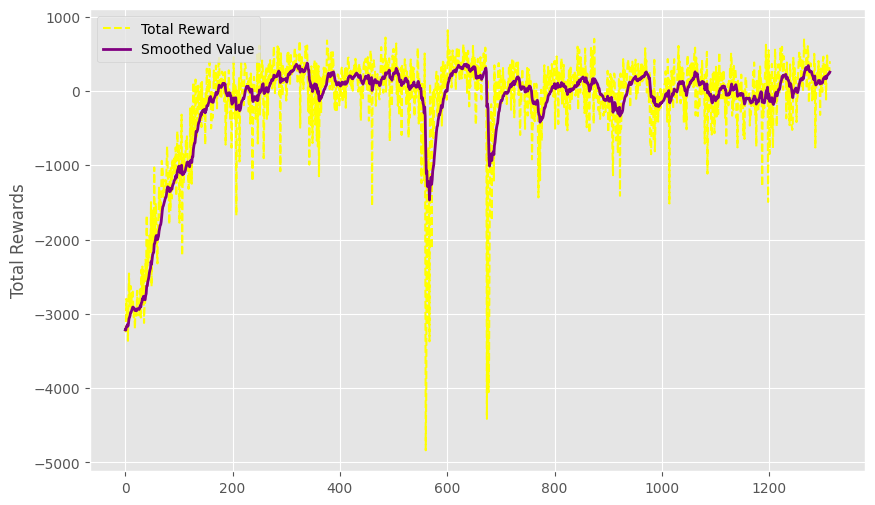

 44%|████▍     | 1314/3000 [34:42<42:49,  1.52s/it, Total Reward=400]

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.ion()

# Create a tqdm progress bar
progress_bar = tqdm.tqdm(range(num_episodes), postfix={'Total Reward': 0, 'Loss': 0})

# RL algorithm training loop
for episode in progress_bar:
    total_reward = 0
    state = env.reset()
    time_step = 0

    while True:
        time_step += 1

        # Convert the original state to the suitable format for the network
        state_desc = env.disc2state(state)
        state_list = convert_state_to_list(state_desc, env_features)
        state_tensor = torch.tensor(state_list, dtype=torch.float32)

        action = choose_action(your_network, state_tensor)

        # Take the chosen action and observe the next state and reward
        next_state, reward, done, _ = env.step((action))

        # Convert the next state to the suitable format for the network
        next_state_desc = env.disc2state(next_state)
        next_state_list = convert_state_to_list(next_state_desc, env_features)
        next_state_tensor = torch.tensor(next_state_list, dtype=torch.float32, device=device)


        # Hint: You may want to collect experiences from the environment to update the agent in batches!
        your_network.buffer.rewards.append(reward)
        your_network.buffer.is_terminals.append(done)

        # update PPO agent
        if time_step % 125 == 0:
            your_network.update()


        # loss = calculate_loss(
        #     ## TODO: FILL IN PARAMS FOR CALLING calculate_loss
        # )

        # optimizer.zero_grad()
        # loss.backward()

        # optimizer.step()

        state = next_state
        total_reward += reward

        if done:
            break


    rewards_list.append(total_reward)
    episodes.append(episode)

    live_plot({'Total Reward': rewards_list}, fig)

    # Saving the model
    if episode%500 == 0:
      torch.save(your_network, f'model.pth')

    progress_bar.set_postfix({'Total Reward': total_reward})

In [1]:
torch.save(your_network.state_dict(), 'model.pt')

NameError: ignored

# Test Performance

In [69]:
# Initialize the environment
env = Elevator(instance = 4)

# Reset the environment to get the initial state

num_episodes_to_run = 100
rewards = []
# Run episodes using the trained Neural Net
for episode in tqdm.tqdm(range(num_episodes_to_run)):
    state = env.reset()
    total_reward = 0  # Initialize total reward for this episode
    while True:
        # Convert the current state to a dictionary
        state_desc = env.disc2state(state)
        state_list = convert_state_to_list(state_desc, env_features)
        state_tensor = torch.tensor(state_list, dtype=torch.float32).unsqueeze(0)

        # Use the Neural Net to get the action for the current state

        action = choose_action(your_network, state_tensor)

        # Step the environment with the selected action
        next_state, reward, done, _ = env.step(action)

        # Update the total reward for this episode
        total_reward += reward

        # Update the current state for the next iteration
        state = next_state

        if done:
            break
    rewards.append(total_reward)

print(f"\nMean Rewards: {np.mean(rewards)}")
# Don't forget to close the environment when you're done
env.close()

/usr/local/lib/python3.10/dist-packages/pyRDDLGym/Examples /usr/local/lib/python3.10/dist-packages/pyRDDLGym/Examples/manifest.csv
Available example environment(s):
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
CartPole_continuous -> A simple continuous state-action MDP for the classical cart-pole system by Rich Sutton, with actions that describe the continuous force applied to the cart.
SupplyChain -> A supply chain with factory and multiple warehouses.
NewLanguage -> Example with new language features.
NewtonZero -> Example with Newton root-finding method.
PropDBN -> Simple propositional DBN.
SupplyChainNet -> A supply chain network with factory and multiple warehouses.
Traffic -> BLX/QTM traffic model.
Wildfire -> A boolean version of the wildfire fighting domain.
MountainCar -> A simple continuous MDP for the classical mountain car 

/usr/local/lib/python3.10/dist-packages/pyRDDLGym/Core/Env/RDDLConstraints.py:85: UserWarning: Constraint does not have a structure of <action or state fluent> <op> <rhs>, where:
<op> is one of {<=, <, >=, >}
<rhs> is a deterministic function of non-fluents or constants only.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(
100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Mean Rewards: -412.32
